# Disseration Experiment 4l
# Generate SHAP XAI Output (Credit Card Fraud) - Feb 21¶
Ciaran Finnegan February 2024

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
# Import libs
import numpy as np
import pandas as pd

# Import Display libraries
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import raiutils
from raiutils.exceptions import UserConfigValidationException


# Import necessary libraries for ANN model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import necessary libraries for LIME calculations
import lime
import lime.lime_tabular

# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Libraries used in Experiment Creation of XL Output Metrics
import os
import time
import random
import openpyxl

2024-02-22 09:50:27.957840: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 09:50:27.960557: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 09:50:28.008961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 09:50:28.010437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 09:50:28.906187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Function 'example_function' executed in 2.0021 seconds
Result: Result, Execution Time: 2.0021414756774902 seconds


Model Evaluation Functions

In [4]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

Track Experiment Result Functions

In [5]:
%run ./XAI_Experiment_Functions.ipynb

# Load Model

A Neural Network Model has been created in another Kubeflow Notebook and is being used in all the XAI experiments

In [6]:
loaded_model = keras.models.load_model('ccfraud_model')  # If saved as SavedModel

In [7]:
X_test_loaded, y_test_loaded, X_train_loaded, y_train_loaded, df_downsampled_loaded, dfCatCols = load_CC_train_test_data()

In [8]:
#X_train_loaded.head(1)

In [9]:
#y_train_loaded.head(2)

## Re-Display Model Peformance

For illustration, the evualtion metrics of the NN model will be repeated here.

### Re-Scale Data

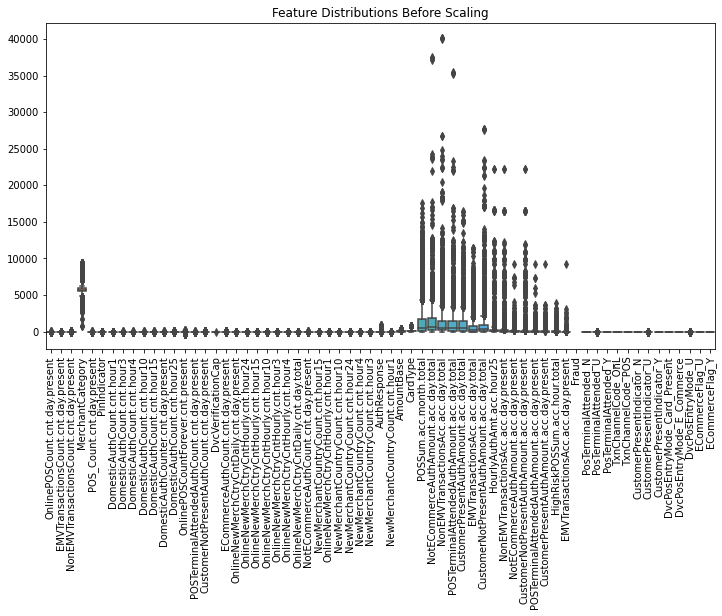



All CC Fraud Binary features (NOT to be scaled): ['PinIndicator', 'PosTerminalAttended_N', 'PosTerminalAttended_U', 'PosTerminalAttended_Y', 'TxnChannelCode_OnL', 'TxnChannelCode_POS', 'CustomerPresentIndicator_N', 'CustomerPresentIndicator_U', 'CustomerPresentIndicator_Y', 'DvcPosEntryMode_Card_Present', 'DvcPosEntryMode_E_Commerce', 'DvcPosEntryMode_U', 'ECommerceFlag_U', 'ECommerceFlag_Y']





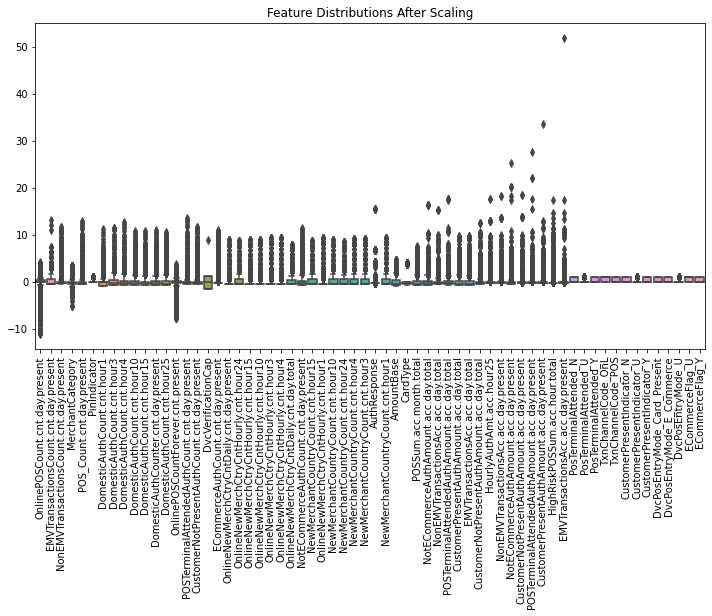

In [10]:
X_train_loaded_scaled, X_test_loaded_scaled, scale_loaded = scale_the_features(X_train_loaded, 
                                                                                X_test_loaded, 
                                                                                df_downsampled_loaded, 
                                                                                'Fraud')

In [11]:
# Set option to display all columns (you can adjust the number as needed)
pd.set_option('display.max_columns', None)

In [12]:
#X_train_loaded_scaled

In [13]:
#X_train_loaded_scaled

### Re-evaluate loaded model

In [14]:
y_pred_loaded = display_model_metrics_tabular(loaded_model, X_test_loaded_scaled, y_test_loaded)

42/42 [==============================] - 0s 1ms/step - loss: 0.3134 - accuracy: 0.8630


42/42 [==============================] - 0s 993us/step


Metric,Value
Accuracy,0.863014
ROC AUC Score,0.939049
Precision (Class 0),0.894137
Recall (Class 0),0.826807
F1-Score (Class 0),0.859155
Precision (Class 1),0.835714
Recall (Class 1),0.900000
F1-Score (Class 1),0.866667


Tablular Done!


### Confusion Matrix

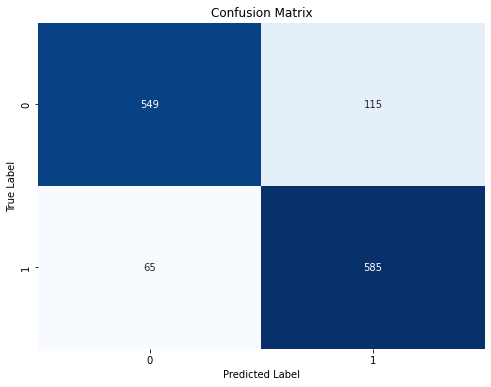

'Confusion Matrix!'

In [15]:
generate_confusion_matrix(y_test_loaded, y_pred_loaded)

# Generate LIME Values (Examples Instances)

Set Up Column Names for Scaling

In [16]:
# Assuming 'X_test' is a numpy array and you have a list of the original column names
# original_feature_names = [col for col in df_downsampled_loaded.columns if col != 'Fraud']

## Select Value + Prepare Function

In [17]:
# Importing necessary libraries - required here to ensure'lime_tabular' routines are available
from lime import lime_tabular

In [18]:
#Jan 6th - use new loaded model
column_names = df_downsampled_loaded.drop('Fraud', axis=1).columns

In [19]:
# Convert NumPy array to DataFrame
X_test_loaded_scaled = pd.DataFrame(X_test_loaded_scaled, columns=column_names)

In [20]:
#Jan 18th - use new loaded mode, and SCALED data
random_observation = X_test_loaded_scaled.sample(1, random_state=42)

In [21]:
instance = random_observation.values.reshape(1, -1)

In [22]:
# Wrapper function to output probabilities for both classes
def predict_proba_wrapper(data):
    
    # Get the probability of the positive class
    prob_pos = loaded_model.predict(data)
    
    # Get the probability of the negative class
    prob_neg = 1 - prob_pos
    
    # Combine and return the probabilities
    return np.hstack([prob_neg, prob_pos])

In [23]:
# Convert NumPy array to DataFrame
X_train_loaded_scaled = pd.DataFrame(X_train_loaded_scaled, columns=column_names)

## Single Instance LIME Explanation

In [24]:
# Jan 18th - use new loaded model and data - SCALED
explainer = lime_tabular.LimeTabularExplainer(X_train_loaded_scaled.values, 
                                              mode='classification',
                                              training_labels=y_train_loaded,
                                              class_names=['Non Fraud', 'Fraud'], 
                                              feature_names=column_names)

In [25]:
# 6. Explaining the prediction using the LIME explainer
# Using our wrapper function for predictions
explanation = explainer.explain_instance(instance[0], predict_proba_wrapper)

157/157 [==============================] - 0s 1ms/step


In [26]:
# Get the prediction for the instance
prediction_probs1 = predict_proba_wrapper(instance[0].reshape(1, -1))

1/1 [==============================] - 0s 59ms/step


In [27]:
print(f'Predicted Probability (Fraud): {prediction_probs1[0][1]:.2f}\n')

Predicted Probability (Fraud): 0.00



In [28]:
# Displaying the LIME explanations for the instance
# 'show_in_notebook' displays the explanation in a Jupyter notebook format
explanation.show_in_notebook(show_table=True)

## Build LIME Explainers for XAI Metrics

### Set Up Explainer for LIME Metrics

In [29]:
# Create a LIME explainer object with a new name
# Jan 18th - use new loaded model and data - SCALED
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_loaded_scaled.values, 
                                                        feature_names=X_train_loaded.columns.tolist(), 
                                                        class_names=['Non Fraud', 'Fraud'], 
                                                        mode='classification')

In [30]:
# Adjusting the prediction function to ensure it provides probabilities for both classes
# Jan 6th - use new loaded model and data
def predict_fn(data):
    prob_pos = loaded_model.predict(data)
    prob_neg = 1 - prob_pos
    return np.hstack([prob_neg, prob_pos])

### Sample Feature LIME Values

In [31]:
def detailed_explanation(instance, real_value):
    """
    Generate LIME explanation for a specific instance and provide a detailed narrative.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    - real_value (int): The true label of the instance.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """

    # Get the prediction for the instance
    prediction_probs = predict_fn(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance using the modified prediction function  
    # Jan 6th - use new loaded model and data
    #exp = lime_explainer.explain_instance(instance, predict_fn, num_features=len(X_train_loaded.columns))
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=15)
    
    # Display the LIME explanation in a readable format
    print(f'\n\n----------------------------------------')
    print(f'Real Value: {real_value}')
    print(f'Predicted Probability (Fraud): {prediction_probs[0][1]:.2f}\n')
    print('Features in Order of Importance:')
    for feature, weight in sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True):
        feature_parts = feature.split(' ')
        feature_name = feature_parts[0]
        feature_value = ' '.join(feature_parts[1:])
        print(f'Feature: {feature_name} | Value: {feature_value} | Weight: {weight:.2f}')
    print('----------------------------------------\n\n')
    
    return exp

# The function is now ready to be used. When called, it will provide a detailed explanation for a given instance.

In [32]:
def detailed_explanation_reverseScaled(instance, real_value, scale_loaded, feature_names):
    """
    Generate LIME explanation for a specific instance and provide a detailed narrative.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    - real_value (int): The true label of the instance.
    - scale_loaded (StandardScaler object): The scaler used for inverse transforming the features.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """
    
    # Convert feature_names to a list if it's a Pandas Index
    if isinstance(feature_names, pd.Index):
        feature_names = feature_names.tolist()
        
        

    # Get the prediction for the instance
    prediction_probs = predict_fn(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance using the modified prediction function
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=7)
    
    # Inverse transform the scaled instance
    original_instance = scale_loaded.inverse_transform(instance.reshape(1, -1)).flatten()
    
    # Display the LIME explanation in a readable format
    print(f'\n\n----------------------------------------')
    print(f'Real Value: {real_value}')
    print(f'Predicted Probability (Fraud): {prediction_probs[0][1]:.2f}\n')
    print('Features in Order of Importance:')
    for feature, weight in sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True):
        feature_parts = feature.split(' ')
        feature_name = feature_parts[0]
        # Check if feature_name is non-numeric before using it to look up the index
        if is_non_numeric(feature_name):
            feature_index = feature_names.index(feature_name)
            original_feature_value = original_instance[feature_index]
            print(f'Feature: {feature_name} | Value: {original_feature_value} | Weight: {weight:.2f}')
        else:
            print(f'Feature: {feature} | Weight: {weight:.2f}')
    print('----------------------------------------\n\n')
    
    
    return exp

In [33]:
# Generating LIME explanations for the first three values in the test dataset
# Jan 18th - use new loaded model and data - SCALED
for i in range(2):
    instance = X_test_loaded_scaled.iloc[i].values
    real_value = y_test_loaded.iloc[i]
    detailed_explanation(instance, real_value)

157/157 [==============================] - 0s 947us/step


----------------------------------------
Real Value: Fraud    1
Name: 0, dtype: int64
Predicted Probability (Fraud): 0.39

Features in Order of Importance:
Feature: PinIndicator | Value: <= 0.00 | Weight: 0.21
Feature: 0.00 | Value: < ECommerceFlag_U <= 1.00 | Weight: -0.12
Feature: POSSum.acc.month.total | Value: <= -0.63 | Weight: 0.11
Feature: EMVTransactionsCount.cnt.day.present | Value: <= -0.51 | Weight: 0.09
Feature: 0.00 | Value: < PosTerminalAttended_Y <= 1.00 | Weight: -0.08
Feature: CustomerPresentAuthAmount.acc.day.total | Value: <= -0.62 | Weight: -0.07
Feature: DvcPosEntryMode_E_Commerce | Value: <= 0.00 | Weight: 0.07
Feature: AuthResponse | Value: <= -0.22 | Weight: -0.06
Feature: OnlineNewMerchCtryCntHourly.cnt.hour1 | Value: <= -0.35 | Weight: -0.06
Feature: POSTerminalAttendedAuthAmount.acc.day.total | Value: <= -0.52 | Weight: 0.05
Feature: 0.00 | Value: < DvcPosEntryMode_Card_Present <= 1.00 | Weight: 0.05


In [34]:
#column_names

In [35]:
def is_non_numeric(s):
    """
    Check if a string is non-numeric (contains alphanumeric characters).

    Parameters:
    - s (str): The string to be checked.

    Returns:
    - bool: True if the string is non-numeric, False otherwise.
    """
    return not s.replace('.', '', 1).isdigit()

In [36]:
# Generating LIME explanations for the first three values in the test dataset
# Jan 18th - use new loaded model and data - SCALED
for i in range(2):
    instance = X_test_loaded_scaled.iloc[i].values
    real_value = y_test_loaded.iloc[i]
    #detailed_explanation_reverseScaled(instance, real_value, scale_loaded, column_names)

Narrative:

For each instance, the output will display the features in order of their importance in determining the predicted probability.

For the instance with a real fraud value of 1:

As the predicted probability of a fraudulent transaction is high, this means the model recognizes patterns in this instance similar to other fraudulent instances from the training data.

Features with positive weights contributed to increasing the probability of a fraud prediction. The larger the weight, the more influential that feature was.

Conversely, features with negative weights worked against the fraud prediction. The larger the negative weight, the more it tried to reduce the probability.




For the two instances with a real fraud value of 0:

If the predicted probability of a fraudulent transaction is low, this means the model recognizes patterns in this instance similar to other non-fraud instances from the training data.

Again, positive weights indicate features that tried to push the prediction towards fraud, while negative weights indicate features that tried to push the prediction away from fraud.




For each feature displayed, the "Value" tells you what the specific value of that feature was for the instance, and the "Weight" tells you how much that feature influenced the prediction. By examining the top features and their weights, you can get a good understanding of why the model made its prediction.







### Prediction  Outputs

In [37]:
#X_test_loaded_scaled
# 1. Direct Evaluation
# Jan 18th - use new loaded model and data - SCALED
sample_instance = X_test_loaded_scaled.iloc[0].values.reshape(1, -1)
print("Direct model prediction:", loaded_model.predict(sample_instance))
print("predict_fn output:", predict_fn(sample_instance))

1/1 [==============================] - 0s 18ms/step
Direct model prediction: [[0.39022395]]
1/1 [==============================] - 0s 43ms/step
predict_fn output: [[0.609776   0.39022395]]


In [38]:
# 2. Check Output Shape
# Jan 6th - use new loaded model and data
assert predict_fn(sample_instance).shape == (1, 2), "Output shape of predict_fn is incorrect!"

1/1 [==============================] - 0s 17ms/step


In [39]:
# 3. Check Probability Sum
# Jan 6th - use new loaded model and data
probabilities = predict_fn(sample_instance)
assert abs(probabilities[0].sum() - 1) < 1e-6, "Probabilities do not sum to 1!"

1/1 [==============================] - 0s 18ms/step


In [40]:
#X_test_loaded_scaled
# 4. Visual Inspection
# Jan 18th - use new loaded model and data - SCALED
print("\nVisual inspection of predict_fn outputs for first 5 test instances:")
for i in range(5):
    instance = X_test_loaded_scaled.iloc[i].values.reshape(1, -1)
    print(f"Instance {i}: {predict_fn(instance)}")


Visual inspection of predict_fn outputs for first 5 test instances:
1/1 [==============================] - 0s 23ms/step
Instance 0: [[0.609776   0.39022395]]
1/1 [==============================] - 0s 18ms/step
Instance 1: [[0.08552474 0.91447526]]
1/1 [==============================] - 0s 18ms/step
Instance 2: [[0.46001965 0.53998035]]
1/1 [==============================] - 0s 19ms/step
Instance 3: [[0.4580872 0.5419128]]
1/1 [==============================] - 0s 17ms/step
Instance 4: [[9.9999493e-01 5.0955659e-06]]


# Prepare LIME Values for Metrics

To achieve your goal, we need to:

Generate explanations for the chosen instances.
Create dataframes for the individual instance features and their corresponding LIME values/weights.
Ensure consistent structure for the LIME values/weights dataframe.
Save the dataframes to output files.
Given the specific structure you need for the LIME values/weights dataframe, we'll also have to ensure that each feature has a consistent number of columns across all instances.

Let's proceed:

We first choose the desired instances, two with a target value of 1 and four with a target value of 0.

The get_detailed_explanation function generates LIME explanations for an instance 
and returns the feature values and LIME values/weights.

## Generate LIME Details 

In [41]:
# Function to get LIME explanations for an instance, function returns explanations
def get_detailed_explanation(instance):
    """
    Generate LIME explanation for a specific instance.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    
    Returns:
    - feature_values (list): List of feature values for the instance.
    - lime_values (list): List of tuples containing LIME values and weights for the instance.
    """
    # Generate LIME explanation for the instance
    print("Instance type: ", type(instance))
    print("Instance length: ", len(instance))
    
    exp = lime_explainer.explain_instance(instance,
                                          predict_fn,
                                          num_features=32)
                                          #num_features=len(X_train_loaded.columns))
    
    feature_values = instance.tolist()
    lime_values = exp.as_list()
    
    return feature_values, lime_values

We then loop over the chosen instances, get their feature values and 
LIME explanations, and store them in lists.

## Generate LIME Explanations

In [42]:
@timeit
def generate_lime_explanations(df, chosen_indices):
    
    # Lists to store instance features and LIME values/weights
    features_data = []
    lime_data = []

    # Generate explanations for the chosen instances
    for index in chosen_indices:
        print(f'Index is {index}')
        feature_values, lime_values = get_detailed_explanation(df.loc[index].values)
        features_data.append(feature_values)
        lime_data.append(lime_values)
    
    # Jan 6th - use new loaded model and data
    # Convert features data to a DataFrame
    features_df = pd.DataFrame(features_data, columns=X_train_loaded.columns.tolist())

    # Ensure consistent structure for the LIME values/weights dataframe
    max_columns = max(len(lime_values) for lime_values in lime_data) * 2  # Multiply by 2 to account for values and weights
    lime_array = []

    for lime_values in lime_data:
        lime_values_array = []
        for feature, weight in lime_values:
            lime_values_array.extend([feature, weight])
        # Padding to ensure consistent number of columns
        lime_values_array.extend([None] * (max_columns - len(lime_values_array)))
        lime_array.append(lime_values_array)

    lime_df = pd.DataFrame(lime_array)
    
    return features_df, lime_df

In [43]:
import re

def extract_feature_names2(feature_descriptors):
    """
    Extracts feature names from a list of LIME explanation descriptors, 
    accommodating complex feature names including periods and other special characters.

    Parameters:
    - feature_descriptors (list of str): A list of strings containing LIME explanation descriptors.

    Returns:
    - list of str: A list containing the extracted feature names.
    """
    
    # Define the regex pattern to match feature names, allowing for periods, underscores, and alphanumeric characters
    pattern = r'(?<![\d<>=])\b[a-zA-Z_.]+[a-zA-Z0-9_.]*\b'
    
    # Initialize an empty list to store the extracted feature names
    raw_feature_names = []
    
    # Iterate over each descriptor in the input list
    for descriptor in feature_descriptors:
        # Use regex to find all substrings that match the pattern of a feature name
        matches = re.findall(pattern, descriptor)
        if matches:
            # Assuming the first match is the feature name, add it to the list
            raw_feature_names.append(matches[0])
        else:
            # Fallback in case no match is found (shouldn't happen with correct input)
            raw_feature_names.append(descriptor)
    
    # Print the extracted feature names
    print("Extracted Feature Names:")
    #for name in raw_feature_names:
    #    print(name)
    
    # Return the list of extracted feature names
    return raw_feature_names

In [44]:
# Example usage
feature_descriptors = [
    'CustomerPresentIndicator_N > 1.12', 
    '-1.16 < TxnChannelCode_OnL <= 0.86', 
    '>= 2.5 Age', 
    'Income <= -0.5',
    '0.5 < DomesticAuthCount.cnt.hour1 <= 1.0'
]

In [45]:
# Call the function and get the list of feature names
extracted_feature_names = extract_feature_names2(feature_descriptors)

Extracted Feature Names:


## Generate LIME Explanations 2

In [46]:
def extract_feature_names(feature_descriptors):
    """
    Extracts feature names from a list of LIME explanation descriptors.

    Parameters:
    - feature_descriptors (list of str): A list of strings containing LIME explanation descriptors.

    Returns:
    - list of str: A list containing the extracted feature names.
    """
    pattern = r'(?<![\d<>=])\b[a-zA-Z_.]+[a-zA-Z0-9_.]*\b'
    raw_feature_names = []
    for descriptor in feature_descriptors:
        matches = re.findall(pattern, descriptor)
        if matches:
            raw_feature_names.append(matches[0])
        else:
            raw_feature_names.append(descriptor)
    
    # Optionally, print the names
    #print("Extracting Feature Names:")
    #for name in raw_feature_names:
    #    print(name)
    #print("Feature Names Extracted:")
    
    return raw_feature_names

In [47]:
def extract_feature_names_with_default(feature_descriptors, all_feature_names):
    """
    Extracts feature names and aligns them with the original feature names, setting default weight to 0.

    Parameters:
    - feature_descriptors (list of tuples): LIME explanation descriptors and weights.
    - all_feature_names (list of str): All feature names in the order they appear in the instance.

    Returns:
    - list of tuples: A list containing the feature names and weights, aligned with all_feature_names.
    """
    # Create a dictionary for quick lookup of weights by feature name
    feature_weights = {re.findall(r'(?<![\d<>=])\b[a-zA-Z_.]+[a-zA-Z0-9_.]*\b', desc)[0]: weight for desc, weight in feature_descriptors}
    
    # Create structured list with default weight of 0 for features not in explanations
    structured_list = [(feature, feature_weights.get(feature, 0)) for feature in all_feature_names]
    
    return structured_list

In [48]:
def get_detailed_explanation2(instance):
    """
    Generate LIME explanation for a specific instance and extract feature names.

    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    
    Returns:
    - feature_values (list): List of feature values for the instance.
    - lime_values (list): List of tuples containing LIME values and weights for the instance.
    - feature_names (list): List of feature names for which LIME provided explanations.
    """

    exp = lime_explainer.explain_instance(instance,
                                          predict_fn,
                                          num_features=16)
                                          
    feature_values = instance.tolist()
    lime_values = exp.as_list()
    
    # Extract the feature names from the LIME explanations
    feature_descriptors = [item[0] for item in lime_values]
    feature_names = extract_feature_names(feature_descriptors)
    
    
    # Get all feature names in the order they appear in the instance
    all_feature_names = X_train_loaded.columns.tolist()
    
    # Extract the feature names and weights, and align them with all features, defaulting to 0
    lime_values_structured = extract_feature_names_with_default(lime_values, all_feature_names)
    
    
    return feature_values, lime_values, feature_names, lime_values_structured

In [49]:
@timeit
def generate_lime_explanations2(df, chosen_indices):
    
    # Lists to store instance features and LIME values/weights
    features_data = []
    lime_data = []

    # Generate explanations for the chosen instances
    for index in chosen_indices:
        print(f'Index is {index}')
        feature_values, lime_values, feature_names, lime_values_structured = get_detailed_explanation2(df.loc[index].values)
        features_data.append(feature_values)
        lime_data.append(lime_values)
    
    # Jan 6th - use new loaded model and data
    # Convert features data to a DataFrame
    features_df = pd.DataFrame(features_data, columns=X_train_loaded.columns.tolist())

    # Ensure consistent structure for the LIME values/weights dataframe
    max_columns = max(len(lime_values) for lime_values in lime_data) * 2  # Multiply by 2 to account for values and weights
    lime_array = []

    for lime_values in lime_data:
        lime_values_array = []
        for feature, weight in lime_values:
            lime_values_array.extend([feature, weight])
        # Padding to ensure consistent number of columns
        lime_values_array.extend([None] * (max_columns - len(lime_values_array)))
        lime_array.append(lime_values_array)

    lime_df = pd.DataFrame(lime_array)
    
    return features_df, lime_df, lime_values_structured

In [50]:
@timeit
def generate_lime_explanations3(df, chosen_indices):
    # Lists to store instance features, LIME values/weights, and structured LIME explanations
    features_data = []
    lime_data = []
    lime_structured_data = []  # New list to store structured LIME data

    # Generate explanations for the chosen instances
    for index in chosen_indices:
        print(f'Index is {index}')
        feature_values, lime_values, feature_names, lime_values_structured = get_detailed_explanation2(df.loc[index].values)
        features_data.append(feature_values)
        lime_data.append(lime_values)
        lime_structured_data.append(lime_values_structured)  # Append structured LIME explanations

    # Convert features data to a DataFrame - function output 1
    features_df = pd.DataFrame(features_data, columns=X_train_loaded.columns.tolist())
    
    
    
    # Ensure consistent structure for the LIME values/weights dataframe
    max_columns = max(len(lime_values) for lime_values in lime_data) * 2  # Multiply by 2 to account for values and weights
    lime_array = []

    for lime_values in lime_data:
        lime_values_array = []
        for feature, weight in lime_values:
            lime_values_array.extend([feature, weight])
        # Padding to ensure consistent number of columns
        lime_values_array.extend([None] * (max_columns - len(lime_values_array)))
        lime_array.append(lime_values_array)

    # Convert feature Lime explanation and weights data to a DataFrame - - function output 2    
    lime_df = pd.DataFrame(lime_array)

    
    
    # Create a DataFrame for structured LIME data that alternates feature names and LIME weights
    # Prepare column names for the new DataFrame
    feature_names = X_train_loaded.columns.tolist()
    column_names = []
    for i, feature_name in enumerate(feature_names, start=1):
        column_names.append(feature_name)  # Feature name
        column_names.append(f'Feature_Weight_{i}')  # Corresponding weight column

    # Convert structured LIME data into a format suitable for DataFrame construction
    lime_structured_array = []
    for lime_values_structured in lime_structured_data:
        row_data = []
        for feature, weight in lime_values_structured:
            row_data.extend([feature, weight])
        lime_structured_array.append(row_data)

    # Create the DataFrame with structured LIME explanations - function output 3
    lime_structured_df = pd.DataFrame(lime_structured_array, columns=column_names)
    
    
    
    return features_df, lime_df, lime_structured_df

The provided Python function; 

  --  get_detailed_explanation(instance)  --

is designed to generate explanations for a specific instance in the credit card fraud dataset using the LIME (Local Interpretable Model-agnostic Explanations) framework. 

Understanding... 

  -- exp.as_list() --


This method call returns a list of tuples, where each tuple contains two elements:

 - Feature Name or Descriptor: A string describing a feature (input variable) of the instance being explained. For a credit card fraud dataset, this could be features like transaction amount, transaction time, or various anonymized features often found in such datasets.
 
 - LIME Value (Weight or Coefficient): A floating-point number indicating the weight or importance of the feature towards the model's prediction for this specific instance. This value helps to understand how each feature contributes to the model's prediction, whether positively (increasing the likelihood of being classified as fraud) or negatively (decreasing the likelihood of being classified as fraud).
 
The output from exp.as_list() essentially provides a local explanation for why the model made a specific prediction for an instance. Each tuple in the list indicates the direction and magnitude of a feature's impact on the prediction, giving insights into the model's behavior at a fine-grained level.

The feature values are straightforwardly converted to a dataframe.
For the LIME values/weights dataframe, we ensure a consistent number of columns 
across all instances by determining the maximum number of columns needed (max_columns) 
and then padding each instance's LIME values/weights with None values to match this maximum.

# XAI Experiments - Metrics Capture

## Suppress Warnings to clean up output

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Break out Model Test Data into a list of dataframes

### Create Test Data for Experiment Input

Ensure 'X_test' and 'y_test' Are DataFrames with Proper Columns

In [52]:
# Assuming 'X_test' is a numpy array and you have a list of the original column names
original_feature_names = [col for col in df_downsampled_loaded.columns if col != 'Fraud']

# Ensure X_test_loaded has the correct column names (if necessary)
X_test_loaded.columns = original_feature_names

In [53]:
# Combine X_test_loaded and y_test into a single DataFrame
df_TestData = pd.concat([X_test_loaded, y_test_loaded], axis=1)

### Split the DataFrame into 20 consecutive smaller DataFrames

In [54]:
# Split the DataFrame into 20 consecutive smaller DataFrames
split_size, list_df = split_TestData_into_nn_Blocks(df_TestData, num_splits = 20)

Original DF Length: 1314
Split Size: 65


### Check Label Count for Stability Metrics

In [55]:
# Count the occurrence of each unique value in the 'Fraud' column
fraud_counts = df_TestData['Fraud'].value_counts()

# Display the counts
print("Breakdown of 'Fraud' and non-Fraud label records in df_TestData:")
print(fraud_counts)

Breakdown of 'Fraud' and non-Fraud label records in df_TestData:
0    664
1    650
Name: Fraud, dtype: int64


### Add a routine to check output values

In [56]:
# Display starting points in the first nn sub dataframes
startBlockDisplay(df_TestData, split_size, 1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,DomesticAuthCount.cnt.hour15,DomesticAuthCounter.cnt.day.present,DomesticAuthCount.cnt.hour25,OnlinePOSCountForever.cnt.present,POSTerminalAttendedAuthCount.cnt.day.present,CustomerNotPresentAuthCount.cnt.day.present,DvcVerificationCap,ECommerceAuthCount.cnt.day.present,OnlineNewMerchCtryCntDaily.cnt.day.present,OnlineNewMerchCtryCntHourly.cnt.hour24,OnlineNewMerchCtryCntHourly.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour10,OnlineNewMerchCtryCntHourly.cnt.hour3,OnlineNewMerchCtryCntHourly.cnt.hour4,OnlineNewMerchCtryCntDaily.cnt.day.total,NotECommerceAuthCount.cnt.day.present,NewMerchantCountryCount.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour1,NewMerchantCountryCount.cnt.hour10,NewMerchantCountryCount.cnt.hour24,NewMerchantCountryCount.cnt.hour4,NewMerchantCountryCount.cnt.hour3,AuthResponse,NewMerchantCountryCount.cnt.hour1,AmountBase,CardType,POSSum.acc.month.total,NotECommerceAuthAmount.acc.day.total,NonEMVTransactionsAcc.acc.day.total,POSTerminalAttendedAuthAmount.acc.day.total,CustomerPresentAuthAmount.acc.day.total,EMVTransactionsAcc.acc.day.total,CustomerNotPresentAuthAmount.acc.day.total,HourlyAuthAmt.acc.hour25,NonEMVTransactionsAcc.acc.day.present,NotECommerceAuthAmount.acc.day.present,CustomerNotPresentAuthAmount.acc.day.present,POSTerminalAttendedAuthAmount.acc.day.present,CustomerPresentAuthAmount.acc.day.present,HighRiskPOSSum.acc.hour.total,EMVTransactionsAcc.acc.day.present,PosTerminalAttended_N,PosTerminalAttended_U,PosTerminalAttended_Y,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,1,0,1,5541,1,0,1,1,1,1,1,1,1,1,1,0,2,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,45,75,45,45,45,45,45,0,0,45,45,45,0,45,45,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1


## Confirm Starting Point in External LIME XAI XL File

The code below acts so that for each dataframe in the list just created the following actions are carried out;

Check if an XAI results XL spreadsheet called 'LIME_XAI_Metrics_Experiments.xls' exists;

If not create an empty XL spreadsheet with the name 'LIME_XAI_Metrics_Experiments.xls', and then define a variable called ‘Sample’ with an integer value of 1 and print the value of 'Sample' to output.

If and XL spreadsheet called 'LIME_XAI_Metrics_Experiments.xls' does exist, then read the entries in the spreadsheet in the first column named ‘Sample Number’ and create a variable in this Python program named ‘Sample’ that is one integer value higher than the highest integer number column named ‘Sample Number’ in the XL, and print this value of 'Sample' to output.

In [57]:
# Create a sequential number as an identifier for each DataFrame
list_df = {f'df_{i + 1}': list_df[i] for i in range(len(list_df))}

In [58]:
# File path for the LIME XAI metrics results spreadsheet
LIME_xai_file_path = 'LIME_XAI_Metrics_Experiments.xlsx'  # Stored locally

In [59]:
# Call Function to update or create the spreadsheet and determine the 'Sample' number
# Process each dataframe in 'list_df'
sample = return_next_sample_number_to_process(list_df, LIME_xai_file_path, "LIME")

Sample Number for current LIME XAI DataFrame: 20


## Select Next Dataframe to Process

---------------------------------

	
Extend the Python code so that the code reads in the dataframe from 'list df' that corresponds to the integer value in the 
variable named ‘Sample’. 

Assign this dataframe the name 'df_Selected_from_List'.


----------------------------------

### Initialize Dataframe to Capture Re-start Point as None

In [60]:
# Initialize df_Selected_from_List as None
df_Selected_from_List = None

### Extract test data block to restart XAI metrics process

In [61]:
df_Selected_from_List, key = select_restart_testdata_block(df_Selected_from_List, 
                                                           list_df, 
                                                           LIME_xai_file_path)

DataFrame selected for Sample Number 20 witk key df_20


In [62]:
# If no DataFrame is selected (e.g., if 'Sample' exceeds the number of DataFrames in list_df)
if 'df_Selected_from_List' not in locals():
    print("No DataFrame selected. The 'Sample' number may exceed the number of DataFrames in list_df.")

-----------------------------

## Generate XAI Metrics from Dataframe

### Generate the LIME Values for the Test Data Block

#### Pre-Process Values for Data Block

In [63]:
#df_Selected_from_List.head(2)

In [64]:
#print(df_Selected_from_List.index)

#### Scale the feature values

Call Scaling Function

In [65]:
#original_feature_names
# Assuming 'X_test' is a numpy array and you have a list of the original column names
original_feature_names = [col for col in df_downsampled_loaded.columns if col != 'Fraud']

In [66]:
# Scale the feature inputs so that they work with the SHAP generation processs
df_Selected_Scaled_Data_from_List = scale_feature_inputs(df_Selected_from_List, 
                                                         original_feature_names)

In [67]:
#df_Selected_Scaled_Data_from_List

In [68]:
#print(df_Selected_Scaled_Data_from_List.index)

In [69]:
# Dynamically determine start and end indices
start_index = df_Selected_from_List.index[0]  # First index of the DataFrame
print(f'Start Index is : {start_index}')

Start Index is : 1235


In [70]:
end_index = df_Selected_from_List.index[-1]  # Last index of the DataFrame
print(f'End Index is : {end_index}')

End Index is : 1299


In [71]:
# Get the range of indices as a list
index_range = list(range(df_Selected_Scaled_Data_from_List.index[0],
                         df_Selected_Scaled_Data_from_List.index[-1] + 1))

In [72]:
#print(index_range)

Set limit value (for debugging)

In [73]:
# A 'zero' limit value will process the entire data block
limit_data_block_rows = 0 # A zero value processes the entire data block

In [74]:
# Jan 6th - use new loaded model and data
default_1_indices = index_range

In [75]:
# For debugging allow a partial subset of data in the data block to be processes
if limit_data_block_rows > 0:
    chosen_indices = list(np.random.choice(default_1_indices, limit_data_block_rows)) 
else:
    chosen_indices = [i for i in range(65)]   

In [76]:
#print(chosen_indices)

In [77]:
chosen_indices.sort()

In [78]:
#print(chosen_indices)

Extract the label values from the data block

In [79]:
y_test_block_labels_df = df_Selected_Scaled_Data_from_List['Fraud']

In [80]:
#y_test_block_labels_df.shape

#### Get LIME Values for Data Block

In [81]:
df_Selected_from_List = df_Selected_from_List.drop('Fraud', axis=1)

In [82]:
df_Selected_Scaled_Data_from_List = df_Selected_Scaled_Data_from_List.drop('Fraud', axis=1)

In [83]:
# Feb 12th - fix assignment of weights to features
results_LIME, exec_time_LIME = generate_lime_explanations3(df_Selected_Scaled_Data_from_List, 
                                                          chosen_indices)

Index is 0
157/157 [==============================] - 0s 942us/step
Index is 1
157/157 [==============================] - 0s 931us/step
Index is 2
157/157 [==============================] - 0s 952us/step
Index is 3
157/157 [==============================] - 0s 1ms/step
Index is 4
157/157 [==============================] - 0s 944us/step
Index is 5
157/157 [==============================] - 0s 953us/step
Index is 6
157/157 [==============================] - 0s 928us/step
Index is 7
157/157 [==============================] - 0s 1ms/step
Index is 8
157/157 [==============================] - 0s 954us/step
Index is 9
157/157 [==============================] - 0s 1ms/step
Index is 10
157/157 [==============================] - 0s 928us/step
Index is 11
157/157 [==============================] - 0s 1ms/step
Index is 12
157/157 [==============================] - 0s 1ms/step
Index is 13
157/157 [==============================] - 0s 919us/step
Index is 14
157/157 [==============================] -

In [84]:
# Unpack the results to get features_df, lime_df
features_df_LIME, lime_exp_weights_df, lime_values_structured = results_LIME

In [85]:
#features_df_LIME

In [86]:
#lime_exp_weights_df

In [87]:
#lime_values_structured

### Remove Feature Names from Feature/Weights Dataframe

In [88]:
# LIME Values needs to be limited to numeric values
xai_Lime_values_df_numeric = lime_values_structured.select_dtypes(include=[np.number])

In [89]:
#xai_Lime_values_df_numeric

-----------------------------

### Generate Identity Metric

#### Run a Basic Test First

In [90]:
# Select two random instances from the LIME dataframe
random_indices = np.random.choice(xai_Lime_values_df_numeric.index, size=2, replace=False)
instance_1 = xai_Lime_values_df_numeric.iloc[random_indices[0]]
instance_2 = xai_Lime_values_df_numeric.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances
distance = get_euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")


Calculating Euclidean distance...


Euclidean distance between instance 8 and instance 39: 0.7130


#### Display LIME Numeric Output

In [91]:
#xai_Lime_values_df_numeric.head(2)

#### Retrieve Identity Score

In [92]:
#print(features_df_LIME.index)

In [93]:
#print(xai_Lime_values_df_numeric.index)

In [94]:
from scipy.spatial import distance
LIME_Identity_Metric = get_identity_metric(features_df_LIME, xai_Lime_values_df_numeric, "LIME")

Instance 0:   Current matches: 0
	Closest feature instance: 10 (Distance: 3.3426)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 1:   Current matches: 1
	Closest feature instance: 31 (Distance: 4.2198)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 2:   Current matches: 2
	Closest feature instance: 16 (Distance: 1.5537)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 3:   Current matches: 2
	Closest feature instance: 8 (Distance: 9.6087)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 4:   Current matches: 3
	Closest feature instance: 62 (Distance: 3.8399)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 5:   Current matches: 3
	Closest feature instance: 25 (Distance: 2.9062)
	Closest LIME instance: {closest_xai_idx} (Distance: {

#### Display Identity Score Metric

In [95]:
LIME_Identity_Number = "{:.2f}%".format(LIME_Identity_Metric)
display_text("LIME Identity Metric Score: " + LIME_Identity_Number)

In [96]:
# Read in XAI Metric for Identity
XAI_Ident_Metric_1 = LIME_Identity_Metric

-----------------------------------

### Generate Stability Metric

#### Pre-Processing of Stability Input Data

In [97]:
#features_df_LIME.shape

In [98]:
#xai_Lime_values_df_numeric.index

In [99]:
#y_test_loaded.shape

In [100]:
#y_test_block_labels_df.shape

In [101]:
#y_test_block_labels_df.index

In [102]:
#print('y_test_block_labels_df')
#print(y_test_block_labels_df)

In [103]:
# Adjust the label value input to match earlier adjustments in LIME value creations
if limit_data_block_rows > 0:
    y_test_block_labels_df = y_test_block_labels_df.iloc[:limit_data_block_rows]    

In [104]:
#y_test_block_labels_df.shape

In [105]:
# Assigning the column name 'Fraud'
y_test_block_labels_df.columns = ['Fraud']

In [106]:
df = pd.DataFrame(y_test_block_labels_df)

In [107]:
# Count the occurrence of each unique value in the 'Fraud' column
fraud_counts_label = df['Fraud'].value_counts()

# Display the counts
print("Breakdown of 'Fraud' and non-Fraud label records in df_TestData:")
print(fraud_counts_label)

Breakdown of 'Fraud' and non-Fraud label records in df_TestData:
1    43
0    22
Name: Fraud, dtype: int64


In [108]:
# Counting the occurrences of each label
label_counts = df['Fraud'].value_counts()

# Finding the label with the most entries
largest_label = label_counts.idxmax()

# Assigning it to largest_label_count
largest_label_count = label_counts[largest_label]

print("Label with most entries:", largest_label)
print("Count of this label:", largest_label_count)

Label with most entries: 1
Count of this label: 43


#### Retrieve Stability Score

In [109]:
# Jan 18th - use new loaded model and data - SCALED
LIME_Stability_Metric = get_stability_metric_y(xai_Lime_values_df_numeric, 
                                               y_test_block_labels_df, 
                                               largest_label, 
                                               'LIME')

Number of Instances in Cluster '0': 20
Number of Instances in Cluster '1': 45

For Class '0':
Total Instances: total_class_0: 22
Matching Cluster '0' Instances (matches_0): 4

For Class '1':
Total Instances: total_class_1: 43
Matching Cluster '1' Instances (matches_1): 27


This is the function in XAI_METRICS_FUNCTIONS -- STABILITY -- LIME



Percentage of matches: 47.69% : 31 Matches of 65 Entries


#### Display Stability Score Metric

In [110]:
LIME_Stability_Number = "{:.2f}%".format(LIME_Stability_Metric)
display_text("SHAP Stability Metric Score: " + LIME_Stability_Number)

In [111]:
# Read in XAI Metric for Stability
XAI_Stability_Metric_2 = LIME_Stability_Metric

----------------------------

### Generate Seperability Metric

#### Retrieve Seperability Score

In [112]:
#print(features_df_LIME.index)

In [113]:
#print(xai_Lime_values_df_numeric.index)

In [114]:
#features_df_LIME

In [115]:
#xai_Lime_values_df_numeric

In [116]:
LIME_Seperability_Metric = get_seperability_metric(features_df_LIME, 
                                                   xai_Lime_values_df_numeric, 
                                                   "LIME",
                                                   0.95, # threshold  #0.51 #0.99 #0.80
                                                   0.05) # tolerance)       #0.01 #0.35

1:Before Dup check:Lenght of features df: 65
1:Before Dup check:Lenght of xai_values_df: 65


2:After Dup check:Lenght of features df: 65
2:After Dup check:Lenght of xai_values_df: 65
Index: 0 Successfully identified sufficient separation
Index: 1 Successfully identified sufficient separation
Index: 2 Failure to identify sufficient separation
Index: 3 Successfully identified sufficient separation
Index: 4 Successfully identified sufficient separation
Index: 5 Successfully identified sufficient separation
Index: 6 Successfully identified sufficient separation
Index: 7 Successfully identified sufficient separation
Index: 8 Successfully identified sufficient separation
Index: 9 Successfully identified sufficient separation
Index: 10 Successfully identified sufficient separation
Index: 11 Failure to identify sufficient separation
Index: 12 Failure to identify sufficient separation
Index: 13 Successfully identified sufficient separation
Index: 14 Successfully identified sufficient separatio

#### Display Seperability Score Metric

In [117]:
LIME_Seperability_Number = "{:.2f}%".format(LIME_Seperability_Metric)
display_text("LIME Seperability Metric Score: " + LIME_Seperability_Number)

In [118]:
# Read in XAI Metric for Seperability
XAI_Seperability_Metric_3 = LIME_Seperability_Metric

-----------------------------------

### Generate Similarity Metric

#### Retrieve Similarity Score

In [119]:
#print(features_df_LIME.index)

In [120]:
#print(xai_Lime_values_df_numeric.index)

In [121]:
LIME_Similarity_Metric = get_similarity_metric(features_df_LIME, 
                                               xai_Lime_values_df_numeric, 
                                               "LIME", 
                                               use_dbscan=False)


Optimal number of clusters: 4
Group 1 (Row Count: 31) Mean Distance: 0.56
Group 2 (Row Count: 16) Mean Distance: 0.31
Group 3 (Row Count: 1) Mean Distance: N/A
Group 4 (Row Count: 17) Mean Distance: 0.33


#### Display Similarity Score Metric

In [122]:
LIME_Similarity_Number = "{:6.2f}".format(LIME_Similarity_Metric)
display_text("LIME Similarity Metric Value: " + LIME_Similarity_Number)

In [123]:
# Read in XAI Metric for Similarity
XAI_Similarity_Metric_4 = LIME_Similarity_Metric

----------------------------

### Display Final Set of Metrics (this run)

In [124]:
# Print the results
print(f"XAI Ident Metric 1: {XAI_Ident_Metric_1}")
print(f"XAI Stability Metric 2: {XAI_Stability_Metric_2}")
print(f"XAI Seperability Metric 1: {XAI_Seperability_Metric_3}")
print(f"XAI Similarity Metric 1: {XAI_Similarity_Metric_4}")
print(f"XAI Time Metric 5: {exec_time_LIME} seconds")

XAI Ident Metric 1: 35.38461538461539
XAI Stability Metric 2: 47.69230769230769
XAI Seperability Metric 1: 84.61538461538461
XAI Similarity Metric 1: 0.3994920344843306
XAI Time Metric 5: 754.8462624549866 seconds


----------------------------------

## Write Out Metrics to XL

In [125]:
write_xai_Metrics_to_XL(LIME_xai_file_path, 
                        sample, 
                        LIME_Identity_Metric, 
                        LIME_Stability_Metric, 
                        LIME_Seperability_Metric, 
                        LIME_Similarity_Metric, 
                        exec_time_LIME, 
                        df_Selected_from_List,
                        "LIME")

LIME DataFrame selected for Sample Number 20 witk key df_20
